# Hodgkin-Huxley Model: Spike Train Analysis

This notebook analyzes the generation and characteristics of spike trains in response to stimuli.

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from src.model import HodgkinHuxleyModel
from src.visualization import plot_membrane_potential, plot_phase_plane

plt.style.use('seaborn-darkgrid')

/var/folders/j5/9drs1nyn0c37q_29h5sv9xdh0000gn/T/ipykernel_49206/2569201320.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


## Current Input Configurations

This section allows flexible definition of current inputs for the Hodgkin-Huxley model simulation.

In [3]:
import numpy as np

class CurrentInput:
    @staticmethod
    def constant(amplitude=50, start=5, end=None):
        """Create a constant current input.
        
        Args:
            amplitude (float): Current amplitude (μA/cm²)
            start (float): Start time of current injection
            end (float): End time of current injection (None means runs to end of simulation)
        
        Returns:
            function: Current input function
        """
        def current_func(t):
            if end is not None:
                return amplitude if start <= t <= end else 0
            return amplitude if t >= start else 0
        return current_func
    
    @staticmethod
    def ramp(start_amplitude=0, end_amplitude=50, start_time=5, duration=10):
        """Create a linear ramp current input.
        
        Args:
            start_amplitude (float): Initial current amplitude
            end_amplitude (float): Final current amplitude
            start_time (float): Start time of ramp
            duration (float): Duration of ramp
        
        Returns:
            function: Current input function
        """
        def current_func(t):
            if start_time <= t < start_time + duration:
                # Linear interpolation
                progress = (t - start_time) / duration
                return start_amplitude + progress * (end_amplitude - start_amplitude)
            elif t >= start_time + duration:
                return end_amplitude
            return start_amplitude
        return current_func
    
    @staticmethod
    def sinusoidal(amplitude=0.75, frequency=0.5, phase=0, offset=0):
        """Create a sinusoidal current input.
        
        Args:
            amplitude (float): Peak current amplitude
            frequency (float): Frequency of oscillation (Hz)
            phase (float): Phase shift (radians)
            offset (float): DC offset
        
        Returns:
            function: Current input function
        """
        def current_func(t):
            return offset + amplitude * np.sin(2 * np.pi * frequency * t + phase)
        return current_func
    
    @staticmethod
    def sawtooth(amplitude=50, frequency=1, phase=0, offset=0):
        """Create a sawtooth wave current input.
        
        Args:
            amplitude (float): Peak current amplitude
            frequency (float): Frequency of wave (Hz)
            phase (float): Phase shift (radians)
            offset (float): DC offset
        
        Returns:
            function: Current input function
        """
        def current_func(t):
            # Use np.mod to create sawtooth wave
            return offset + amplitude * (((t * frequency + phase/2/np.pi) % 1) - 0.5) * 2
        return current_func
    
    @staticmethod
    def zap(max_amplitude=1e-9, fmin=0, fmax=80, duration=2):
        """Create a zap current input with linearly increasing frequency.
        
        Args:
            max_amplitude (float): Maximum amplitude of the oscillating current
            fmin (float): Initial frequency (Hz)
            fmax (float): Final frequency (Hz)
            duration (float): Total duration of the simulation (sec)
        
        Returns:
            function: Current input function
        """
        def current_func(t):
            # Ensure t is within the duration
            if t > duration:
                return 0
            
            # Calculate instantaneous frequency
            df = (fmax - fmin) / duration
            f_inst = fmin + df * t
            
            # Calculate current based on instantaneous frequency
            return max_amplitude * np.sin(2 * np.pi * f_inst * t)
        
        return current_func
    
    @staticmethod
    def custom(func):
        """Wrap an arbitrary function as a current input.
        
        Args:
            func (callable): A function that takes time as input and returns current
        
        Returns:
            function: Current input function
        """
        return func

## Sustained Current Response

Demonstrate various current input configurations

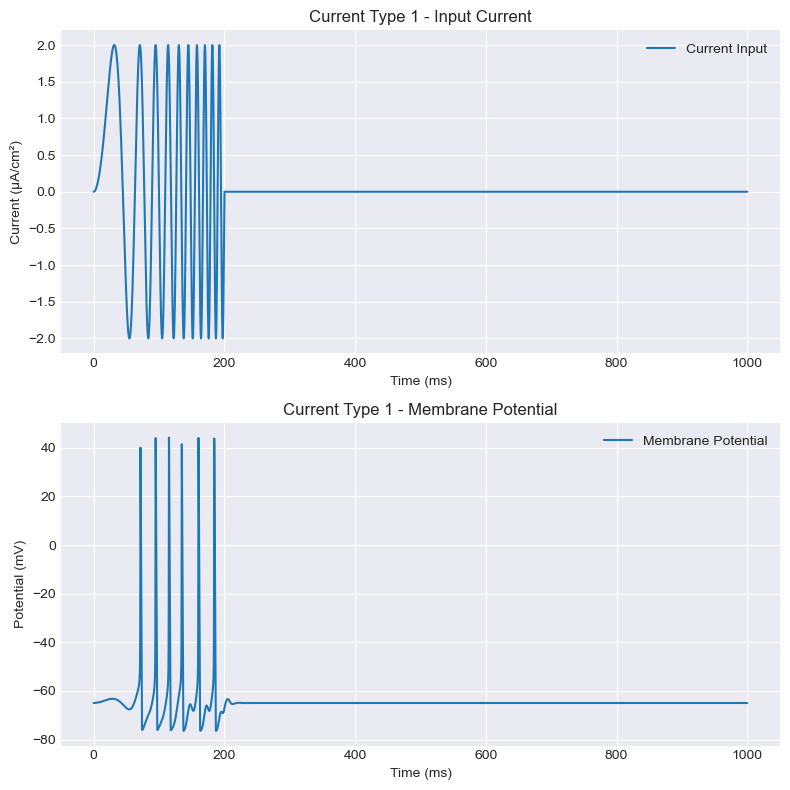

In [10]:
# Define an example custom function
def custom_pulse(t):
    """A custom pulse function with multiple peaks"""
    # function that has a constant current then slowly ramps down to zero
    amp = 5
    if t < 50:
        return amp
    else:
        # linear ramp down
        return 10 + amp - t/20


# Choose current input type
current_types = [
    # CurrentInput.constant(amplitude=50, start=5),
    # CurrentInput.ramp(start_amplitude=0, end_amplitude=50, start_time=5, duration=10),
    # CurrentInput.sinusoidal(amplitude=7.5, frequency=0.05, offset=0),
    # CurrentInput.sawtooth(amplitude=0.5, frequency=0.05, offset=0),
    # CurrentInput.custom(custom_pulse)
    CurrentInput.zap(max_amplitude=2, fmin=0, fmax=0.05, duration=200)
]

# Simulation parameters
t_span = [0, 1000]  # 100ms simulation
dt = 0.01

# Plot for each current type
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for i, current_func in enumerate(current_types):
    # Reset model for each simulation
    model = HodgkinHuxleyModel()
    
    # Simulate
    t, V, n, m, h = model.simulate(t_span, dt=dt, I_ext_func=current_func)
    
    # Compute current values for plotting
    I_ext = np.array([current_func(t_i) for t_i in t])
    
    # Plot Current Input
    axes[0].plot(t, I_ext, label='Current Input')
    axes[0].set_title(f'Current Type {i+1} - Input Current')
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('Current (μA/cm²)')
    axes[0].legend()
    
    # Plot Membrane Potential
    axes[1].plot(t, V, label='Membrane Potential')
    axes[1].set_title(f'Current Type {i+1} - Membrane Potential')
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_ylabel('Potential (mV)')
    axes[1].legend()

plt.tight_layout()
plt.savefig('../data/results/current_and_potential.png')
plt.show()

## Frequency Analysis

Analyze spike frequency for different current types

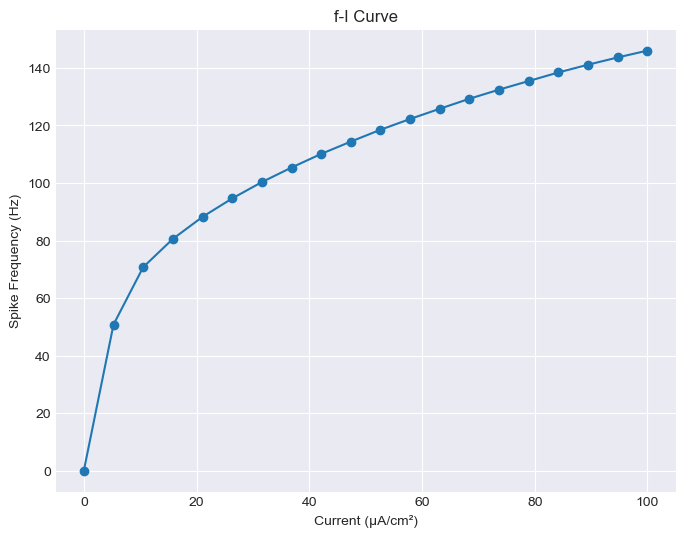

In [5]:
def calculate_spike_frequency(V, t, threshold=-20):
    """Calculate spike frequency from voltage trace."""
    spikes = np.where((V[1:] >= threshold) & (V[:-1] < threshold))[0]
    
    if len(spikes) < 2:
        return 0
    
    intervals = np.diff(t[spikes])
    
    return 1000 / np.mean(intervals)

# Sweep for constant current
current_range = np.linspace(0, 100, 20)
frequencies = []

for I in current_range:
    current_func = CurrentInput.constant(amplitude=I, start=5)
    model = HodgkinHuxleyModel()
    t, V, n, m, h = model.simulate([0, 100], I_ext_func=current_func)
    freq = calculate_spike_frequency(V, t)
    frequencies.append(freq)

# Plot f-I curve
plt.figure(figsize=(8, 6))
plt.plot(current_range, frequencies, 'o-')
plt.xlabel('Current (μA/cm²)')
plt.ylabel('Spike Frequency (Hz)')
plt.title('f-I Curve')
plt.grid(True)
plt.savefig('../data/results/f-I_curve.png')
plt.show()